# Taxonomic Diversity vs. Functional Diversity
In this analysis, I want to assess the correlation between taxonomic and functional diversity.

In [24]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np
import scipy.stats as stats
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from sklearn.utils import resample
from sklearn.metrics import DistanceMetric
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

## Gather taxonomic diversity

In [2]:
# Load the necessary count data
counts = pd.read_csv('../../data/kallisto/tpm.csv', engine='pyarrow')
## This is the transcript read mapping, prior to protein prediction!
# Rename the first column to transcript_id
counts = counts.rename(columns={'target_id': 'transcript_id'})
print(f'{len(counts)} transcripts were quantified (on the nucleotide level) in the kallisto run')
# Transform the data to the long format
counts = counts.melt(id_vars=['transcript_id'],var_name='sample', value_name='TPM')
counts.head()

7113509 transcripts were quantified (on the nucleotide level) in the kallisto run


,transcript_id,sample,TPM
0,c_000000000001,B_120_S11,0.233985
1,c_000000000002,B_120_S11,0.000000
2,c_000000000003,B_120_S11,0.000000
3,c_000000000004,B_120_S11,0.000000
4,c_000000000005,B_120_S11,0.000000


In [3]:
## Load eukprot annotations
data_tax = pd.read_table(f'../../data/annotation/taxonomy_eukprot/eukprot_DB.firsthit.90plus_alnscore.m8', header=None)
print(f'The eukprot annotation file contains {len(data_tax)} rows')
# Fix transcript names in the first column so that they equal the transcript identifiers in the count files
data_tax.iloc[:, 0] = data_tax.iloc[:, 0].str.split(".", expand=True).drop(columns=1)

## In the second column, split of the EukProt ID off
eukprot_ID = data_tax.iloc[:, 1].str.split("_", expand=True)[0]
data_tax.iloc[:, 1] = eukprot_ID
data_tax.columns = ['query_id', 'target_id', 'p_ident', 'alnlen', 'mismatch', 'gapopen', 'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bits']

## Add taxonomic information
eukprot_taxonomy = pd.read_table('../../data/annotation/taxonomy_eukprot/EukProt_included_data_sets.v03.2021_11_22.txt')
print(f'The eukprot taxonomy file contains {len(eukprot_taxonomy)} rows')

# Drop the columns that are not needed
eukprot_taxonomy.drop(columns=['Previous_Names', 'Replaces_EukProt_ID', 'Data_Source_URL', 'Data_Source_Name', 'Paper_DOI', 'Actions_Prior_to_Use',
       'Data_Source_Type', 'Notes', 'Columns_Modified_Since_Previous_Version', 'Merged_Strains',
       'Alternative_Strain_Names', '18S_Sequence_GenBank_ID', '18S_Sequence',
       '18S_Sequence_Source', '18S_Sequence_Other_Strain_GenBank_ID',
       '18S_Sequence_Other_Strain_Name', '18S_and_Taxonomy_Notes'], inplace=True)

# Swap the _ to a space in the Name_to_Use column
eukprot_taxonomy['Name_to_Use'] = eukprot_taxonomy['Name_to_Use'].str.replace('_', ' ')

# Merge the annotation and taxonomy files
data_tax = data_tax.merge(eukprot_taxonomy, left_on='target_id', right_on='EukProt_ID', how='left')
print(f'The eukprot annotation merged with taxonomy file contains {len(data_tax)} rows')

# Drop the columns that are not needed
data_tax.drop(columns=['target_id', 'gapopen', 'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bits'], inplace=True)

The eukprot annotation file contains 468593 rows
The eukprot taxonomy file contains 993 rows
The eukprot annotation merged with taxonomy file contains 468593 rows


In [4]:
print(data_tax.columns)
data_tax.head()

Index(['query_id', 'p_ident', 'alnlen', 'mismatch', 'EukProt_ID',
       'Name_to_Use', 'Strain', 'Genus_UniEuk', 'Epithet_UniEuk',
       'Supergroup_UniEuk', 'Taxogroup1_UniEuk', 'Taxogroup2_UniEuk',
       'Taxonomy_UniEuk'],
      dtype='object')


,query_id,p_ident,alnlen,mismatch,EukProt_ID,Name_to_Use,Strain,Genus_UniEuk,Epithet_UniEuk,Supergroup_UniEuk,Taxogroup1_UniEuk,Taxogroup2_UniEuk,Taxonomy_UniEuk
0,c_000001100514,0.960,108,4,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans
1,c_000001112094,0.962,91,3,EP00568,Trieres chinensis,PLY606,Trieres,chinensis,Stramenopiles,Ochrophyta,Diatomeae,Eukaryota;Diaphoretickes;Sar;Stramenopiles;'GOS clade';Gyrista;Ochrophyta;'BD clade';Diatomeae;Bacillariophytina;Mediophyceae;Odontellophycidae;Trieres;Trieres chinensis;strain PLY-606
2,c_000001228303,0.952,158,8,EP00568,Trieres chinensis,PLY606,Trieres,chinensis,Stramenopiles,Ochrophyta,Diatomeae,Eukaryota;Diaphoretickes;Sar;Stramenopiles;'GOS clade';Gyrista;Ochrophyta;'BD clade';Diatomeae;Bacillariophytina;Mediophyceae;Odontellophycidae;Trieres;Trieres chinensis;strain PLY-606
3,c_000002029341,1.000,121,0,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans
4,c_000001170245,0.955,127,6,EP00090,Calanus glacialis,NaN,Calanus,glacialis,Opisthokonta,Metazoa,Arthropoda,Eukaryota;Amorphea;Obazoa;Opisthokonta;Holozoa;Choanozoa;Metazoa;Animalia;'parahoxozoa';Bilateria;Protostomia;Ecdysozoa;Panarthropoda;Arthropoda;Mandibulata;Pancrustacea;Copepoda;Calanoida;'megacalanoids';Calanidae;Calanus;Calanus glacialis


In [5]:
# Create a dataset that is species x sample with the TPM values
data = data_tax.merge(counts, left_on='query_id', right_on='transcript_id', how='left')
data = data.drop(columns='query_id')

# Add sample metadata
meta = pd.read_csv('../../samples.csv', sep=';', index_col=0)
data = data.merge(meta, left_on= 'sample', right_on= 'sample', how = 'left')

tax_info = 'Name_to_Use'
aggregation_level = 'sample'

data = data[[aggregation_level, tax_info, 'TPM']]

In [6]:
# Create a dataset that is species x sample with the TPM values
data = data_tax.merge(counts, left_on='query_id', right_on='transcript_id', how='left')
data = data.drop(columns='query_id')

# Add sample metadata
meta = pd.read_csv('../../samples.csv', sep=';', index_col=0)
data = data.merge(meta, left_on= 'sample', right_on= 'sample', how = 'left')

tax_info = 'Name_to_Use'
aggregation_level = 'sample'

data = data[[aggregation_level, tax_info, 'TPM']]

# Group by taxonomic information and sample values, sum TPM per taxonomic group

# Count how many non-zero transcripts are in each sample for each taxonomic group
data = data[data['TPM'] > 1].groupby([tax_info, aggregation_level]).count().reset_index()

data = data.pivot(index=tax_info, columns=aggregation_level, values='TPM')
data = data.fillna(0)

data.head()

sample,1_130_S31,1_330_S34,1_700_S32,1_780_S33,1_ZG02_S35,2_120_S40,2_130_S36,2_330_S39,2_700_S37,2_780_S38,...,E_330_S22,E_700_S20,E_780_S21,E_ZG02_S24,F_120_S29,F_130_S25,F_330_S28,F_700_S26,F_780_S27,F_ZG02_S30
Name_to_Use,,,,,,,,,,,,,,,,,,,,,
Abedinium dasypus,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Abedinium folium,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,...,1.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0
Abeoforma whisleri,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0
Acanthamoeba castellanii,3.0,2.0,7.0,1.0,0.0,0.0,2.0,0.0,8.0,5.0,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0
Acanthocystis sp HF-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Count the amount of species per sample that have a total TPM > 50
data[data > 50].count()

sample
1_130_S31     15
1_330_S34     13
1_700_S32      7
1_780_S33     12
1_ZG02_S35    15
              ..
F_130_S25     21
F_330_S28     19
F_700_S26     19
F_780_S27     15
F_ZG02_S30    17
Length: 62, dtype: int64

In [53]:
# Check how many genera exist per month that have > 50 non-zero TPM transcripts
## Per sample, count the number of genera that have > 50 TPM
taxonomic_bin_abundance = data[data > 100].count(axis=0).reset_index()
taxonomic_bin_abundance.columns = ['sample', 'num_species']

## Add metadata
taxonomic_bin_abundance = taxonomic_bin_abundance.merge(meta[['month', 'station']], left_on='sample', right_index=True, how='left')

# Plot the number of genera per month that have > 50 TPM
fig = px.box(taxonomic_bin_abundance, x='month', y='num_species',
             category_orders={'month': ['July_2020', "August_2020", "September_2020", "November_2020", 
               "December_2020", "January_2021", "February_2021", "April_2021", 
               "May_2021", "June_2021", "July_2021"]})

fig.show()

In [57]:
# ANOVA for months
model_month = ols('num_species ~ month', data=taxonomic_bin_abundance).fit()
anova_table_month = sm.stats.anova_lm(model_month, typ=2)

# ANOVA for stations
model_stations = ols('num_species ~ station', data=taxonomic_bin_abundance).fit()
anova_table_stations = sm.stats.anova_lm(model_stations, typ=2)

print("ANOVA Table for the difference in active species between months:\n", anova_table_month)
print("\nANOVA Table for the difference in active species between stations:\n", anova_table_stations)

ANOVA Table for the difference in active species between months:
               sum_sq    df         F        PR(>F)
month     882.487097  10.0  9.872086  6.184762e-09
Residual  455.900000  51.0       NaN           NaN

ANOVA Table for the difference in active species between stations:
                sum_sq    df         F    PR(>F)
station     18.268915   5.0  0.154995  0.977664
Residual  1320.118182  56.0       NaN       NaN



Checking Normality of Residuals for Months...
ShapiroResult(statistic=0.9586699604988098, pvalue=0.035555414855480194)


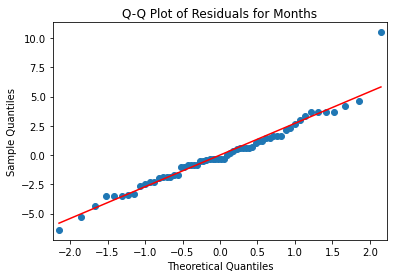


Checking Homogeneity of Variances for the Months...
LeveneResult(statistic=0.8629996747909529, pvalue=0.5724886840686185)


In [56]:
# Check normality of residuals for the months
print("\nChecking Normality of Residuals for Months...")
print(stats.shapiro(model_month.resid))
sm.qqplot(model_month.resid, line='s')
plt.title("Q-Q Plot of Residuals for Months")
plt.show()

# Check homogeneity of variances for the months
print("\nChecking Homogeneity of Variances for the Months...")
print(stats.levene(*[taxonomic_bin_abundance['num_species'][taxonomic_bin_abundance['month'] == s] for s in taxonomic_bin_abundance['month'].unique()]))

In [59]:
# I guess in July 2021 there is an outlier here
## Check in which jul_2021 sample this outlier is
july_2021_abundance = data[data > 100][['7_120_S61', '7_130_S57', '7_330_S58', '7_700_S59', '7_780_S60', '7_ZG02_S62']]
print(july_2021_abundance.count(axis=0))


sample
7_120_S61      6
7_130_S57      5
7_330_S58      2
7_700_S59     16
7_780_S60      2
7_ZG02_S62     2
dtype: int64


In [61]:
# Print the species that are present in station 700 in July 2021
july_2021_abundance = data[data > 100][['7_700_S59']]
print(july_2021_abundance[july_2021_abundance['7_700_S59'] > 0])

sample                        7_700_S59
Name_to_Use                            
Acartia fossae                    123.0
Asterionellopsis glacialis        148.0
Chaetoceros brevis                101.0
Chaetoceros debilis               143.0
Crassostrea gigas                 269.0
Eurytemora affinis                111.0
Mnemiopsis leidyi                 119.0
Noctiluca scintillans            3203.0
Nonionella stella                 168.0
Odontella aurita                  144.0
Oithona nana                      111.0
Pseudictyota dubia                158.0
Schmidingerella arcuata           105.0
Schmidingerella taraikaensis      134.0
Thalassiosira rotula              133.0
Tripos fusus                     2437.0


In [62]:
# Post-hoc Tukey's HSD test to check which months are different
posthoc = pairwise_tukeyhsd(taxonomic_bin_abundance['num_species'], taxonomic_bin_abundance['month'], alpha=0.05)
print(posthoc)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1        group2     meandiff p-adj   lower    upper  reject
--------------------------------------------------------------------
   April_2021    August_2020   0.8333    1.0  -5.6679  7.3346  False
   April_2021  December_2020   4.8333 0.3263  -1.6679 11.3346  False
   April_2021  February_2021      6.9 0.0415   0.1437 13.6563   True
   April_2021   January_2021      1.9 0.9967  -4.8563  8.6563  False
   April_2021      July_2020  -2.1667 0.9875  -8.6679  4.3346  False
   April_2021      July_2021     -1.0    1.0  -7.5013  5.5013  False
   April_2021      June_2021  -3.6667 0.7144 -10.1679  2.8346  False
   April_2021       May_2021  -1.6667 0.9984  -8.1679  4.8346  False
   April_2021  November_2020      4.5 0.4293  -2.0013 11.0013  False
   April_2021 September_2020   8.1667 0.0042   1.6654 14.6679   True
  August_2020  December_2020      4.0 0.4385  -1.8149  9.8149  False
  August_2020  February_2021   6.0

In [64]:
# Extract the names of the genera that have > 100 TPM in at least one sample
taxonomic_bin_abundance = data[data > 100].count(axis=1).reset_index()
taxonomic_bin_abundance.columns = ['taxonomic_bin', 'abundant_in_samples']
taxonomic_bin_abundance.head()

,taxonomic_bin,abundant_in_samples
0,Abedinium dasypus,0
1,Abedinium folium,0
2,Abeoforma whisleri,0
3,Acanthamoeba castellanii,0
4,Acanthocystis sp HF-20,0


In [65]:
# Save a list of taxa that are at least once present with more than 100 TPM
abundant_taxa = taxonomic_bin_abundance[taxonomic_bin_abundance['abundant_in_samples'] >= 1]['taxonomic_bin']

In [66]:
# Only retain species with that have more than 500 non-zero transcripts at least once
print(data.shape)
print(len(abundant_taxa))

(746, 62)
53


In [68]:
# To obtain biodiversity measures, we'll only retain taxonomic bins with more than 50 non-zero transcripts in at least one sample
# Create a dataset that is species x sample with the TPM values
data = data_tax.merge(counts, left_on='query_id', right_on='transcript_id', how='left')
data = data.drop(columns='query_id')

# Add sample metadata
meta = pd.read_csv('../../samples.csv', sep=';', index_col=0)
data = data.merge(meta, left_on= 'sample', right_on= 'sample', how = 'left')

data = data[[aggregation_level, tax_info, 'TPM']]

# Group by taxonomic information and sample values, sum TPM per taxonomic group

# Count how many non-zero transcripts are in each sample for each taxonomic group
data = data[data['TPM'] > 1].groupby([tax_info, aggregation_level]).sum().reset_index()

data = data.pivot(index=tax_info, columns=aggregation_level, values='TPM')
data = data.fillna(0)

# Filter for the most abundant taxonomic bins
data = data.filter(items=abundant_taxa, axis=0)

# Save the data
data.to_csv(f'../../data/analysis/{tax_info}_{aggregation_level}_TPM_sum_bins100plus.csv')

In [69]:
data.head()

sample,1_130_S31,1_330_S34,1_700_S32,1_780_S33,1_ZG02_S35,2_120_S40,2_130_S36,2_330_S39,2_700_S37,2_780_S38,...,E_330_S22,E_700_S20,E_780_S21,E_ZG02_S24,F_120_S29,F_130_S25,F_330_S28,F_700_S26,F_780_S27,F_ZG02_S30
Name_to_Use,,,,,,,,,,,,,,,,,,,,,
Acartia fossae,1863.89414,4475.13952,60.53836,792.21355,3155.82450,968.68868,452.38849,723.98149,314.08238,627.33382,...,1697.06555,602.40026,1198.22644,489.50601,529.18085,383.79674,518.47015,795.55492,250.85922,446.77193
Ancora sagittata,277.16110,40.08182,34.48037,90.38764,83.37614,68.51945,244.45186,103.36429,68.47484,47.21080,...,165.74384,32.18043,40.29188,34.59967,39.12768,603.23141,60.99378,242.32932,161.61251,61.52050
Asterionellopsis glacialis,7.82853,42.53273,3.81131,5.66548,33.31470,279.63446,63.96801,475.34195,15.55096,1264.82111,...,29.16891,9.03285,14.87121,110.21272,263.25399,74.20303,90.55285,13.91994,289.04818,195.09468
Bathycoccus prasinos,102.17980,71.91078,74.45514,99.41662,42.25037,57.66063,49.45068,2.68405,22.56736,63.83962,...,10.28739,85.63470,19.66027,0.00000,71.97831,36.00820,107.53884,21.17933,6.97533,26.61149
Calanus glacialis,464.19100,3001.97977,12.39109,200.25295,858.11274,1788.11645,944.40327,452.14443,712.03137,195.15471,...,652.56219,110.26970,376.36576,269.84407,497.56300,151.52302,186.79589,2026.05445,93.76730,132.16566


Run the diversity.R script to calculate the Chao1 index for each sample.

In [70]:
# Load the biodiversity indices
biodiversity = pd.read_csv('../../data/analysis/eukprot_bins100plus_biodiversity_estimates.csv', index_col=0)

In [71]:
biodiversity.head()

,shannon,simpson,species,evenness
1_130_S31,3.136442,0.944625,49,0.805906
1_330_S34,2.508804,0.881383,48,0.648069
1_700_S32,2.748359,0.900147,49,0.706189
1_780_S33,2.861173,0.911230,48,0.739092
1_ZG02_S35,2.963734,0.922663,49,0.761529


## Functional richness

In [72]:
# Load the annotation data
data_func_annot = pd.read_csv('../../data/annotation/functional_eggnog/functional_annotation.emapper.annotations', sep = '\t', engine = 'pyarrow')

# Fix transcript names in the first column so that they equal the transcript identifiers in the count files
# This is necessary because TransDecoder adds .p2 or .p1 to the sequence identifiers
data_func_annot.iloc[:, 0] = data_func_annot.iloc[:, 0].str.split(".", expand=True).drop(columns=1)

Let's first check how good the annotations are. We should only retain the annotation hits with the lowest e-value. 

In [73]:
print(f'number of rows in eggNOG annotation: {len(data_func_annot)}')
print(f'number of unique query sequences in eggNOG annotation: {len(data_func_annot.iloc[:, 0].unique())}')

number of rows in eggNOG annotation: 2235576
number of unique query sequences in eggNOG annotation: 2235576


In [74]:
# From the functional data, only retain the rows with the lowest e-values for a given query sequence
data_func_annot = data_func_annot.sort_values(by=['#query', 'evalue'], ascending=True).drop_duplicates(subset=['#query'], keep='first')

In [75]:
# Combine the functional annotation with the count data
data_func_annot = data_func_annot.merge(counts, left_on='#query', right_on='transcript_id', how='left')

In [76]:
data_func_annot.columns

Index(['#query', 'seed_ortholog', 'evalue', 'score', 'eggNOG_OGs',
       'max_annot_lvl', 'COG_category', 'Description', 'Preferred_name', 'GOs',
       'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
       'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs',
       'transcript_id', 'sample', 'TPM'],
      dtype='object')

In [77]:
func_info = 'KEGG_ko'
aggregation_level = 'sample'

data_func = data_func_annot[[aggregation_level, func_info, 'TPM']]

# If TPM column is below 1, set it to 0 (Lower limit of detection)
data_func.loc[data_func['TPM'] < 1, 'TPM'] = 0

# Remove rows with low TPM counts
data_func = data_func[data_func['TPM'] > 1]

In [54]:
# Test what to do if columns contain multiple functional values
## First make a list of the values, split on ,
## Explode list
data_func[0:1000].assign(**{func_info:data_func[func_info].str.split(',')}).explode(func_info)

,sample,KEGG_ko,TPM
111,E_700_S20,ko:K09488,1.04824
149,C_120_S18,ko:K01373,1.09695
253,C_780_S15,-,3.76374
315,C_780_S15,-,1.10698
374,A_780_S3,ko:K17086,1.65872
...,...,...,...
32756,5_ZG02_S49,ko:K20721,1.88373
32756,5_ZG02_S49,ko:K20722,1.88373
32792,F_700_S26,ko:K20721,3.38242
32792,F_700_S26,ko:K20722,3.38242


In [78]:
# Comment or uncomment the following line if multiple values are assigned to a transcript!
## split them up
data_func = data_func.assign(**{func_info:data_func[func_info].str.split(',')})
# Now we can explode the functional column
data_func = data_func.explode(func_info)

# If looking at KEGG pathways, only retain rows that have values that contain 'map'
#data_func = data_func[data_func[func_info].str.contains('map')]

# For KEGG KO identifiers, remove the 'ko:' prefix
data_func[func_info] = data_func[func_info].str.replace('ko:', '')

# Remove the rows with no functional annotation
data_func = data_func[data_func[func_info].notna()]
data_func = data_func[data_func[func_info] != '-']

# Group by taxonomic information and sample values, sum TPM
data_func = data_func.groupby([func_info, aggregation_level]).sum().reset_index()

# Reshape the data in a wide format
data_func = data_func.pivot(index=func_info, columns=aggregation_level, values='TPM')

In [79]:
print(len(data_func))
data_func.head()

12046


sample,1_130_S31,1_330_S34,1_700_S32,1_780_S33,1_ZG02_S35,2_120_S40,2_130_S36,2_330_S39,2_700_S37,2_780_S38,...,E_330_S22,E_700_S20,E_780_S21,E_ZG02_S24,F_120_S29,F_130_S25,F_330_S28,F_700_S26,F_780_S27,F_ZG02_S30
KEGG_ko,,,,,,,,,,,,,,,,,,,,,
K00001,3.14142,2.69071,2.37359,4.85430,4.58465,4.73660,13.29097,3.77798,NaN,2.26283,...,2.40210,6.05735,9.06673,5.54520,NaN,1.09709,5.87718,4.83932,1.14953,3.65235
K00002,23.32774,50.19771,2.22837,18.00905,18.86758,20.33044,31.39383,9.51205,7.33712,13.73468,...,24.47865,41.70916,65.35931,19.58537,1.13544,12.91073,25.15855,41.01559,12.11758,12.65185
K00003,NaN,NaN,NaN,1.81630,NaN,14.43270,10.33095,15.56866,1.16391,6.12624,...,3.88841,1.80498,4.50182,4.19860,6.69210,6.71329,2.82139,NaN,15.90375,11.47554
K00004,NaN,1.71749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.16328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K00005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.81425,...,NaN,1.39429,NaN,2.07199,1.15536,NaN,4.70602,1.19430,NaN,1.67393


In [80]:
# Check the distribution of KO counts
data_func.sum(axis=1).describe()

count     12046.000000
mean       1001.675122
std        5579.358206
min           1.001150
25%          17.916725
50%         100.190735
75%         391.511860
max      222666.622210
dtype: float64

In [81]:
# Set NaN values to 0
data_func = data_func.fillna(0)

# Calculate presence/absence data for the functional annotation per sample
# Create a presence/absence matrix, 1 if the transcript is present, 0 if not
functional_diversity = data_func.copy()

functional_diversity[functional_diversity < 1] = 0
functional_diversity[functional_diversity >= 1] = 1

functional_richness =  functional_diversity.sum(axis=0).reset_index()

functional_richness.columns = ['sample', func_info]
functional_richness.set_index('sample', inplace=True)

In [82]:
# Save the data
data_func.to_csv(f'../../data/analysis/{func_info}_{aggregation_level}_TPM_sum.csv')
functional_richness.to_csv(f'../../data/analysis/{func_info}_{aggregation_level}_presence_count.csv')

In [83]:
functional_richness.head()

,KEGG_ko
sample,
1_130_S31,6328.0
1_330_S34,6805.0
1_700_S32,3644.0
1_780_S33,5499.0
1_ZG02_S35,6125.0


## Correlation between taxonomy, biomass, and functional richness

In this part we'll explore the relationship between biodiversity and functional diversity!

In [101]:
# Merge the taxonomic and functional diversity data
plot_data = biodiversity.merge(functional_richness, left_index=True, right_index=True)

# Add the sample metadata
meta = pd.read_csv('../../samples.csv', sep=';', index_col=0)
plot_data = plot_data.merge(meta, left_index=True, right_index=True)

# Add the taxonomic bin abundance data
taxonomic_bin_abundance = data[data > 100].count(axis=0).reset_index()
taxonomic_bin_abundance.columns = ['sample', 'num_species']
plot_data = plot_data.merge(taxonomic_bin_abundance, left_index=True, right_on='sample')

# Change the taxonomic bin column name
plot_data = plot_data.rename(columns={'num_species':'taxonomic_bins'})

# Add the flowcam cell counts, but keep the index
flowcam_counts = pd.read_csv('../../data/flowcam/flowcam_average_cells_per_sample.csv')
plot_data = plot_data.merge(flowcam_counts, left_on=['month', 'station'], right_on=['month', 'station'], how='left').set_index(plot_data.index)

In [102]:
# Or if you already had plot_data and want to add another functional richness parameter
# plot_data = plot_data.merge(functional_richness, left_index=True, right_index=True)

In [103]:
plot_data.head()

,shannon,simpson,species,evenness,KEGG_ko,date,time,month,station,sample,taxonomic_bins,average_cells_L
0,3.136442,0.944625,49,0.805906,6328.0,18/01/2021,9:05,January_2021,130,1_130_S31,19,14.956719
1,2.508804,0.881383,48,0.648069,6805.0,18/01/2021,14:05,January_2021,330,1_330_S34,16,8.156772
2,2.748359,0.900147,49,0.706189,3644.0,18/01/2021,11:45,January_2021,700,1_700_S32,7,380.361039
3,2.861173,0.911230,48,0.739092,5499.0,18/01/2021,13:00,January_2021,780,1_780_S33,15,37.984239
4,2.963734,0.922663,49,0.761529,6125.0,18/01/2021,15:35,January_2021,ZG02,1_ZG02_S35,17,12.049578


In [104]:
plot_data[plot_data['average_cells_L'].isna()]

,shannon,simpson,species,evenness,KEGG_ko,date,time,month,station,sample,taxonomic_bins,average_cells_L
26,2.343964,0.820394,46,0.612218,5285.0,27/07/2021,12:45,July_2021,120,7_120_S61,19,NaN
34,2.718434,0.893658,41,0.732027,4672.0,22/07/2020,11:10,July_2020,330,A_330_S2,5,NaN
37,2.243495,0.788535,45,0.589360,5173.0,23/07/2020,13:50,July_2020,ZG02,A_ZGO2_S6,8,NaN
51,2.929743,0.915457,44,0.774206,6217.0,26/11/2020,9:05,November_2020,130,E_130_S19,23,NaN
53,3.007742,0.928508,47,0.781202,6383.0,26/11/2020,11:00,November_2020,700,E_700_S20,17,NaN


In [105]:
# Plot the amount of large taxonomic bins that have more than 100 nonzero transcripts
fig = px.box(plot_data,
                   x = "month",
                   y='taxonomic_bins',
                   category_orders={'month': ["July_2020", "August_2020", "September_2020", "November_2020", 
                "December_2020", "January_2021", "February_2021", "April_2021", 
                "May_2021", "June_2021", "July_2021"]},)

fig.show()

# Save the plot
fig.write_image("../../figures/biodiversity_functional_diversity/taxonomic_bins_per_month.svg", width = 3.5, height = 2, scale=1, format='svg')

In [106]:
# Plot the amount of large taxonomic bins that have more than 50 nonzero transcripts
fig = px.box(plot_data,
                   x = "month",
                   y='shannon',
                   category_orders={'month': ["July_2020", "August_2020", "September_2020", "November_2020", 
                "December_2020", "January_2021", "February_2021", "April_2021", 
                "May_2021", "June_2021", "July_2021"]},)

fig.show()

# Save the plot
fig.write_image("../../figures/biodiversity_functional_diversity/shannon_diversity_per_month.svg", width = 3.5, height = 2, scale=1, format='svg')


In [107]:
# Plot the functional richness over time
fig = px.box(plot_data,
                   x = "month",
                   y=func_info,
                   category_orders={'month': ["July_2020", "August_2020", "September_2020", "November_2020", 
                "December_2020", "January_2021", "February_2021", "April_2021", 
                "May_2021", "June_2021", "July_2021"]},)

fig.show()

# Save the plot
fig.write_image("../../figures/biodiversity_functional_diversity/functional_richness_per_month.svg", width = 3.5, height = 2, scale=1, format='svg')


In [108]:
# Plot the biomass over time
fig = px.box(plot_data,
                   x = "month",
                   y='average_cells_L',
                   category_orders={'month': ["July_2020", "August_2020", "September_2020", "November_2020", 
                "December_2020", "January_2021", "February_2021", "April_2021", 
                "May_2021", "June_2021", "July_2021"]},)

fig.show()

# Save the plot
fig.write_image("../../figures/biodiversity_functional_diversity/biomass_per_month.svg", width = 3.5, height = 2, scale=1, format='svg')


In [109]:
# First, test the relationship between Shannon diversity and the amount of taxonomic_bins
# Statistical tests
# calculate the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(plot_data['taxonomic_bins'], plot_data['shannon'])

# calculate the correlation coefficient and its p-value
corr_coeff, p_value_corr = stats.pearsonr(plot_data['taxonomic_bins'], plot_data['shannon'])

# calculate descriptive statistics
mean_taxonomic_bins = np.mean(plot_data['taxonomic_bins'])
mean_ko = np.mean(plot_data['shannon'])
std_taxonomic_bins = np.std(plot_data['taxonomic_bins'])
std_ko = np.std(plot_data['shannon'])
min_taxonomic_bins = np.min(plot_data['taxonomic_bins'])
min_ko = np.min(plot_data['shannon'])
max_taxonomic_bins = np.max(plot_data['taxonomic_bins'])
max_ko = np.max(plot_data['shannon'])

# print the results
print("Linear regression results:")
print("Slope: {:.2f}, Intercept: {:.2f}, R-squared: {:.2f}, P-value: {:.4f}, Standard error: {:.2f}".format(slope, intercept, r_value**2, p_value, std_err))
print("\nCorrelation coefficient: {:.2f}, P-value: {:.4f}".format(corr_coeff, p_value_corr))
print("\nDescriptive statistics:")
print("Mean number of taxonomic_bins: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_taxonomic_bins, std_taxonomic_bins, min_taxonomic_bins, max_taxonomic_bins))
print("Mean number of KO identifiers: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_ko, std_ko, min_ko, max_ko))

# Plot variation in taxonomic richness, colored by station
fig = px.scatter(plot_data,
        x = 'taxonomic_bins',
        y = 'shannon',
        color = 'month')

# Update plot size, font, and font size
fig.update_layout(
        width=800,
        height=600,
        font=dict(
            family='Times New Roman',
            size=8
        )
)

fig.update_xaxes(tickfont=dict(family='Times New Roman', size=8))
fig.update_yaxes(tickfont=dict(family='Times New Roman', size=8))

# Add a linear regression line
fig.add_trace(go.Scatter(
        x = plot_data['taxonomic_bins'],
        y = slope * plot_data['taxonomic_bins'] + intercept,
        mode = 'lines',
        line = dict(
                color = 'black',
                width = 1
        )
))

# Convert the size from cm to inches (1 inch = 2.54 cm)
width_in_inches = 8.5 / 2.54
height_in_inches = 7.5 / 2.54

# Save the figure as an SVG file
fig.write_image("../../figures/biodiversity_functional_diversity/taxonomic_bins_shannon.svg", width=int(width_in_inches * 96), height=int(height_in_inches * 96), scale=1, format='svg')

fig.show()


Linear regression results:
Slope: 0.05, Intercept: 1.87, R-squared: 0.43, P-value: 0.0000, Standard error: 0.01

Correlation coefficient: 0.65, P-value: 0.0000

Descriptive statistics:
Mean number of taxonomic_bins: 15.02, Standard deviation: 6.54, Range: 4-27
Mean number of KO identifiers: 2.59, Standard deviation: 0.48, Range: 1.24254584723977-3.32562183093256


In [111]:
# Now, model the relation between functional richness and the Shannon diversity
# Statistical tests
# calculate the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(plot_data['shannon'], plot_data[func_info])

# calculate the correlation coefficient and its p-value
corr_coeff, p_value_corr = stats.pearsonr(plot_data['shannon'], plot_data[func_info])

# calculate descriptive statistics
mean_species = np.mean(plot_data['shannon'])
mean_ko = np.mean(plot_data[func_info])
std_species = np.std(plot_data['shannon'])
std_ko = np.std(plot_data[func_info])
min_species = np.min(plot_data['shannon'])
min_ko = np.min(plot_data[func_info])
max_species = np.max(plot_data['shannon'])
max_ko = np.max(plot_data[func_info])

# print the results
print("Linear regression results:")
print("Slope: {:.2f}, Intercept: {:.2f}, R-squared: {:.2f}, P-value: {:.4f}, Standard error: {:.2f}".format(slope, intercept, r_value**2, p_value, std_err))
print("\nCorrelation coefficient: {:.2f}, P-value: {:.4f}".format(corr_coeff, p_value_corr))
print("\nDescriptive statistics:")
print("Mean number of species: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_species, std_species, min_species, max_species))
print("Mean number of KO identifiers: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_ko, std_ko, min_ko, max_ko))

# Plot variation in taxonomic richness, colored by station
fig = px.scatter(plot_data,
        x = 'shannon',
        y = func_info,
        color = 'month')

# Update plot size, font, and font size
fig.update_layout(
        width=800,
        height=600,
        font=dict(
            family='Times New Roman',
            size=8
        )
)

fig.update_xaxes(tickfont=dict(family='Times New Roman', size=8))
fig.update_yaxes(tickfont=dict(family='Times New Roman', size=8))

# Don't add a linear regression line, because it's not a good fit

# Convert the size from cm to inches (1 inch = 2.54 cm)
width_in_inches = 8.5 / 2.54
height_in_inches = 7.5 / 2.54

# Save the figure as an SVG file
fig.write_image("../../figures/biodiversity_functional_diversity/shannon_KO.svg", width=int(width_in_inches * 96), height=int(height_in_inches * 96), scale=1, format='svg')

fig.show()

Linear regression results:
Slope: 180.98, Intercept: 5165.00, R-squared: 0.01, P-value: 0.4229, Standard error: 224.30

Correlation coefficient: 0.10, P-value: 0.4229

Descriptive statistics:
Mean number of species: 2.59, Standard deviation: 0.48, Range: 1.24254584723977-3.32562183093256
Mean number of KO identifiers: 5633.58, Standard deviation: 834.69, Range: 3642.0-7264.0


In [112]:
# Now, model the relation between functional richness and the number of taxonomic_bins
# Statistical tests
# calculate the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(plot_data['taxonomic_bins'], plot_data[func_info])

# calculate the correlation coefficient and its p-value
corr_coeff, p_value_corr = stats.pearsonr(plot_data['taxonomic_bins'], plot_data[func_info])

# calculate descriptive statistics
mean_taxonomic_bins = np.mean(plot_data['taxonomic_bins'])
mean_ko = np.mean(plot_data[func_info])
std_taxonomic_bins = np.std(plot_data['taxonomic_bins'])
std_ko = np.std(plot_data[func_info])
min_taxonomic_bins = np.min(plot_data['taxonomic_bins'])
min_ko = np.min(plot_data[func_info])
max_taxonomic_bins = np.max(plot_data['taxonomic_bins'])
max_ko = np.max(plot_data[func_info])

# print the results
print("Linear regression results:")
print("Slope: {:.2f}, Intercept: {:.2f}, R-squared: {:.2f}, P-value: {:.4f}, Standard error: {:.2f}".format(slope, intercept, r_value**2, p_value, std_err))
print("\nCorrelation coefficient: {:.2f}, P-value: {:.4f}".format(corr_coeff, p_value_corr))
print("\nDescriptive statistics:")
print("Mean number of taxonomic_bins: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_taxonomic_bins, std_taxonomic_bins, min_taxonomic_bins, max_taxonomic_bins))
print("Mean number of KO identifiers: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_ko, std_ko, min_ko, max_ko))

# Plot variation in taxonomic richness, colored by station
fig = px.scatter(plot_data,
        x = 'taxonomic_bins',
        y = func_info,
        color = 'month')

# Update plot size, font, and font size
fig.update_layout(
        width=800,
        height=600,
        font=dict(
            family='Times New Roman',
            size=8
        )
)

fig.update_xaxes(tickfont=dict(family='Times New Roman', size=8))
fig.update_yaxes(tickfont=dict(family='Times New Roman', size=8))

# Don't add a linear regression line, because it's not a good fit

# Convert the size from cm to inches (1 inch = 2.54 cm)
width_in_inches = 8.5 / 2.54
height_in_inches = 7.5 / 2.54

# Save the figure as an SVG file
fig.write_image("../../figures/biodiversity_functional_diversity/taxonomic_bins_KO.svg", width=int(width_in_inches * 96), height=int(height_in_inches * 96), scale=1, format='svg')

fig.show()

Linear regression results:
Slope: 23.55, Intercept: 5279.99, R-squared: 0.03, P-value: 0.1514, Standard error: 16.20

Correlation coefficient: 0.18, P-value: 0.1514

Descriptive statistics:
Mean number of taxonomic_bins: 15.02, Standard deviation: 6.54, Range: 4-27
Mean number of KO identifiers: 5633.58, Standard deviation: 834.69, Range: 3642.0-7264.0


In [94]:
# Model the relationship between evenness and functional richness
# Statistical tests
# calculate the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(plot_data[func_info], plot_data['evenness'])

# calculate the correlation coefficient and its p-value
corr_coeff, p_value_corr = stats.pearsonr(plot_data[func_info], plot_data['evenness'])

# calculate descriptive statistics
mean_species = np.mean(plot_data[func_info])
mean_biomass = np.mean(plot_data['evenness'])
std_species = np.std(plot_data[func_info])
std_biomass = np.std(plot_data['evenness'])
min_species = np.min(plot_data[func_info])
min_biomass = np.min(plot_data['evenness'])
max_species = np.max(plot_data[func_info])
max_biomass = np.max(plot_data['evenness'])

# print the results
print("Linear regression results:")
print("Slope: {:.2f}, Intercept: {:.2f}, R-squared: {:.2f}, P-value: {:.4f}, Standard error: {:.2f}".format(slope, intercept, r_value**2, p_value, std_err))
print("\nCorrelation coefficient: {:.2f}, P-value: {:.4f}".format(corr_coeff, p_value_corr))
print("\nDescriptive statistics:")
print("Mean number of species: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_species, std_species, min_species, max_species))
print("Mean number of cells per L: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_biomass, std_biomass, min_biomass, max_biomass))

# Plot variation in taxonomic diversity, colored by station
fig = px.scatter(plot_data,
        x = 'KEGG_ko',
        y = 'evenness',
        color = 'month')

# Update plot size, font, and font size
fig.update_layout(
        width=800,
        height=600,
        font=dict(
            family='Times New Roman',
            size=8
        )
)

fig.update_xaxes(tickfont=dict(family='Times New Roman', size=8))
fig.update_yaxes(tickfont=dict(family='Times New Roman', size=8))

# Save the figure as an SVG file
fig.write_image("../../figures/biodiversity_functional_diversity/evenness_KO.svg", width=int(width_in_inches * 96), height=int(height_in_inches * 96), scale=1, format='svg')

fig.show()


Linear regression results:
Slope: 0.00, Intercept: 0.62, R-squared: 0.01, P-value: 0.5002, Standard error: 0.00

Correlation coefficient: 0.09, P-value: 0.5002

Descriptive statistics:
Mean number of species: 5633.58, Standard deviation: 834.69, Range: 3642.0-7264.0
Mean number of cells per L: 0.68, Standard deviation: 0.11, Range: 0.37289003224308-0.854515773132449


In [118]:
# Create copy of data frame with only the samples that have flowcam data
plot_data2 = plot_data[plot_data['average_cells_L'].notna()]

# Statistical tests
# calculate the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(plot_data2['average_cells_L'], plot_data2['taxonomic_bins'])

# calculate the correlation coefficient and its p-value
corr_coeff, p_value_corr = stats.pearsonr(plot_data2['average_cells_L'], plot_data2['taxonomic_bins'])

# calculate descriptive statistics
mean_taxonomic_bins = np.mean(plot_data2['taxonomic_bins'])
mean_biomass = np.mean(plot_data2['average_cells_L'])
std_taxonomic_bins = np.std(plot_data2['taxonomic_bins'])
std_biomass = np.std(plot_data2['average_cells_L'])
min_taxonomic_bins = np.min(plot_data2['taxonomic_bins'])
min_biomass = np.min(plot_data2['average_cells_L'])
max_taxonomic_bins = np.max(plot_data2['taxonomic_bins'])
max_biomass = np.max(plot_data2['average_cells_L'])

# print the results
print("Linear regression results:")
print("Slope: {:.2f}, Intercept: {:.2f}, R-squared: {:.2f}, P-value: {:.4f}, Standard error: {:.2f}".format(slope, intercept, r_value**2, p_value, std_err))
print("\nCorrelation coefficient: {:.2f}, P-value: {:.4f}".format(corr_coeff, p_value_corr))
print("\nDescriptive statistics:")
print("Mean number of taxonomic_bins: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_taxonomic_bins, std_taxonomic_bins, min_taxonomic_bins, max_taxonomic_bins))
print("Mean number of cells per L: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_biomass, std_biomass, min_biomass, max_biomass))

# Plot variation in biomass and taxonomic_bins composition, colored by station
fig = px.scatter(plot_data2,
        x = 'average_cells_L',
        y = 'taxonomic_bins',
        color = 'month')

# Update plot size, font, and font size
fig.update_layout(
        width=800,
        height=600,
        font=dict(
            family='Times New Roman',
            size=8
        )
)

fig.update_xaxes(tickfont=dict(family='Times New Roman', size=8))
fig.update_yaxes(tickfont=dict(family='Times New Roman', size=8))

# Add a linear regression line
fig.add_trace(go.Scatter(
        x = plot_data2['average_cells_L'],
        y = slope * plot_data2['average_cells_L'] + intercept,
        mode = 'lines',
        line = dict(
                color = 'black',
                width = 1
        )
))

# Convert the size from cm to inches (1 inch = 2.54 cm)
width_in_inches = 8.5 / 2.54
height_in_inches = 7.5 / 2.54

# Save the figure as an SVG file
fig.write_image("../../figures/biodiversity_functional_diversity/biomass_taxonomic_bins.svg", width=int(width_in_inches * 96), height=int(height_in_inches * 96), scale=1, format='svg')

fig.show()

Linear regression results:
Slope: -0.00, Intercept: 16.36, R-squared: 0.18, P-value: 0.0011, Standard error: 0.00

Correlation coefficient: -0.42, P-value: 0.0011

Descriptive statistics:
Mean number of taxonomic_bins: 15.07, Standard deviation: 6.51, Range: 4-27
Mean number of cells per L: 983.56, Standard deviation: 2103.98, Range: 8.156771831524296-10169.858309307589


In [119]:
# Add log transformed cell counts
plot_data2['log_average_cells_L'] = np.log10(plot_data2['average_cells_L'])

# Statistical tests
# calculate the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(plot_data2['log_average_cells_L'], plot_data2['taxonomic_bins'])

# calculate the correlation coefficient and its p-value
corr_coeff, p_value_corr = stats.pearsonr(plot_data2['log_average_cells_L'], plot_data2['taxonomic_bins'])

# calculate descriptive statistics
mean_taxonomic_bins = np.mean(plot_data2['taxonomic_bins'])
mean_biomass = np.mean(plot_data2['log_average_cells_L'])
std_taxonomic_bins = np.std(plot_data2['taxonomic_bins'])
std_biomass = np.std(plot_data2['log_average_cells_L'])
min_taxonomic_bins = np.min(plot_data2['taxonomic_bins'])
min_biomass = np.min(plot_data2['log_average_cells_L'])
max_taxonomic_bins = np.max(plot_data2['taxonomic_bins'])
max_biomass = np.max(plot_data2['log_average_cells_L'])

# print the results
print("Linear regression results:")
print("Slope: {:.2f}, Intercept: {:.2f}, R-squared: {:.2f}, P-value: {:.4f}, Standard error: {:.2f}".format(slope, intercept, r_value**2, p_value, std_err))
print("\nCorrelation coefficient: {:.2f}, P-value: {:.4f}".format(corr_coeff, p_value_corr))
print("\nDescriptive statistics:")
print("Mean number of taxonomic_bins: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_taxonomic_bins, std_taxonomic_bins, min_taxonomic_bins, max_taxonomic_bins))
print("Mean number of cells per L: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_biomass, std_biomass, min_biomass, max_biomass))

# Plot variation in taxonomic diversity, colored by station
fig = px.scatter(plot_data2,
        x = 'log_average_cells_L',
        y = 'taxonomic_bins',
        color = 'month')

# Update plot size, font, and font size
fig.update_layout(
        width=800,
        height=600,
        font=dict(
            family='Times New Roman',
            size=8
        )
)

fig.update_xaxes(tickfont=dict(family='Times New Roman', size=8))
fig.update_yaxes(tickfont=dict(family='Times New Roman', size=8))

# Add a linear regression line
fig.add_trace(go.Scatter(
        x = plot_data2['log_average_cells_L'],
        y = slope * plot_data2['log_average_cells_L'] + intercept,
        mode = 'lines',
        line = dict(
                color = 'black',
                width = 1
        )
))

# Save the figure as an SVG file
fig.write_image("../../figures/biodiversity_functional_diversity/log_biomass_taxonomic_bins.svg", width=int(width_in_inches * 96), height=int(height_in_inches * 96), scale=1, format='svg')

fig.show()


Linear regression results:
Slope: -3.94, Intercept: 24.05, R-squared: 0.23, P-value: 0.0002, Standard error: 0.98

Correlation coefficient: -0.48, P-value: 0.0002

Descriptive statistics:
Mean number of taxonomic_bins: 15.07, Standard deviation: 6.51, Range: 4-27
Mean number of cells per L: 2.28, Standard deviation: 0.79, Range: 0.9115183140055959-4.007314902193687


/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_1219/2761247432.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [120]:
# Add log transformed cell counts
plot_data2['log_average_cells_L'] = np.log10(plot_data2['average_cells_L'])

# Statistical tests
# calculate the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(plot_data2['log_average_cells_L'], plot_data2['shannon'])

# calculate the correlation coefficient and its p-value
corr_coeff, p_value_corr = stats.pearsonr(plot_data2['log_average_cells_L'], plot_data2['shannon'])

# calculate descriptive statistics
mean_shannon = np.mean(plot_data2['shannon'])
mean_biomass = np.mean(plot_data2['log_average_cells_L'])
std_shannon = np.std(plot_data2['shannon'])
std_biomass = np.std(plot_data2['log_average_cells_L'])
min_shannon = np.min(plot_data2['shannon'])
min_biomass = np.min(plot_data2['log_average_cells_L'])
max_shannon = np.max(plot_data2['shannon'])
max_biomass = np.max(plot_data2['log_average_cells_L'])

# print the results
print("Linear regression results:")
print("Slope: {:.2f}, Intercept: {:.2f}, R-squared: {:.2f}, P-value: {:.4f}, Standard error: {:.2f}".format(slope, intercept, r_value**2, p_value, std_err))
print("\nCorrelation coefficient: {:.2f}, P-value: {:.4f}".format(corr_coeff, p_value_corr))
print("\nDescriptive statistics:")
print("Mean number of shannon: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_shannon, std_shannon, min_shannon, max_shannon))
print("Mean number of cells per L: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_biomass, std_biomass, min_biomass, max_biomass))

# Plot variation in taxonomic diversity, colored by station
fig = px.scatter(plot_data2,
        x = 'log_average_cells_L',
        y = 'shannon',
        color = 'month')

# Update plot size, font, and font size
fig.update_layout(
        width=800,
        height=600,
        font=dict(
            family='Times New Roman',
            size=8
        )
)

fig.update_xaxes(tickfont=dict(family='Times New Roman', size=8))
fig.update_yaxes(tickfont=dict(family='Times New Roman', size=8))

# Add a linear regression line
fig.add_trace(go.Scatter(
        x = plot_data2['log_average_cells_L'],
        y = slope * plot_data2['log_average_cells_L'] + intercept,
        mode = 'lines',
        line = dict(
                color = 'black',
                width = 1
        )
))

# Save the figure as an SVG file
fig.write_image("../../figures/biodiversity_functional_diversity/log_biomass_shannon.svg", width=int(width_in_inches * 96), height=int(height_in_inches * 96), scale=1, format='svg')

fig.show()


Linear regression results:
Slope: -0.19, Intercept: 3.02, R-squared: 0.10, P-value: 0.0193, Standard error: 0.08

Correlation coefficient: -0.31, P-value: 0.0193

Descriptive statistics:
Mean number of shannon: 2.58, Standard deviation: 0.49, Range: 1.24254584723977-3.32562183093256
Mean number of cells per L: 2.28, Standard deviation: 0.79, Range: 0.9115183140055959-4.007314902193687


/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_1219/3163552441.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [122]:
# Statistical tests
# calculate the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(plot_data2['log_average_cells_L'], plot_data2[func_info])

# calculate the correlation coefficient and its p-value
corr_coeff, p_value_corr = stats.pearsonr(plot_data2['log_average_cells_L'], plot_data2[func_info])

# calculate descriptive statistics
mean_species = np.mean(plot_data2[func_info])
mean_biomass = np.mean(plot_data2['log_average_cells_L'])
std_species = np.std(plot_data2[func_info])
std_biomass = np.std(plot_data2['log_average_cells_L'])
min_species = np.min(plot_data2[func_info])
min_biomass = np.min(plot_data2['log_average_cells_L'])
max_species = np.max(plot_data2[func_info])
max_biomass = np.max(plot_data2['log_average_cells_L'])

# print the results
print("Linear regression results:")
print("Slope: {:.2f}, Intercept: {:.2f}, R-squared: {:.2f}, P-value: {:.4f}, Standard error: {:.2f}".format(slope, intercept, r_value**2, p_value, std_err))
print("\nCorrelation coefficient: {:.2f}, P-value: {:.4f}".format(corr_coeff, p_value_corr))
print("\nDescriptive statistics:")
print("Mean number of species: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_species, std_species, min_species, max_species))
print("Mean number of cells per L: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_biomass, std_biomass, min_biomass, max_biomass))

# Plot variation in taxonomic diversity, colored by station
fig = px.scatter(plot_data2,
        x = 'log_average_cells_L',
        y = func_info,
        color = 'month')

# Update plot size, font, and font size
fig.update_layout(
        width=800,
        height=600,
        font=dict(
            family='Times New Roman',
            size=8
        )
)

fig.update_xaxes(tickfont=dict(family='Times New Roman', size=8))
fig.update_yaxes(tickfont=dict(family='Times New Roman', size=8))

# Add a linear regression line
fig.add_trace(go.Scatter(
        x = plot_data2['log_average_cells_L'],
        y = slope * plot_data2['log_average_cells_L'] + intercept,
        mode = 'lines',
        line = dict(
                color = 'black',
                width = 1
        )
))

# Save the figure as an SVG file
fig.write_image("../../figures/biodiversity_functional_diversity/KO_log_biomass.svg", width=int(width_in_inches * 96), height=int(height_in_inches * 96), scale=1, format='svg')

fig.show()


Linear regression results:
Slope: -281.00, Intercept: 6282.68, R-squared: 0.07, P-value: 0.0492, Standard error: 139.72

Correlation coefficient: -0.26, P-value: 0.0492

Descriptive statistics:
Mean number of species: 5641.26, Standard deviation: 848.45, Range: 3642.0-7264.0
Mean number of cells per L: 2.28, Standard deviation: 0.79, Range: 0.9115183140055959-4.007314902193687


In [123]:
# Statistical tests
# calculate the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(plot_data2['log_average_cells_L'], plot_data2['evenness'])

# calculate the correlation coefficient and its p-value
corr_coeff, p_value_corr = stats.pearsonr(plot_data2['log_average_cells_L'], plot_data2['evenness'])

# calculate descriptive statistics
mean_species = np.mean(plot_data2['evenness'])
mean_biomass = np.mean(plot_data2['log_average_cells_L'])
std_species = np.std(plot_data2['evenness'])
std_biomass = np.std(plot_data2['log_average_cells_L'])
min_species = np.min(plot_data2['evenness'])
min_biomass = np.min(plot_data2['log_average_cells_L'])
max_species = np.max(plot_data2['evenness'])
max_biomass = np.max(plot_data2['log_average_cells_L'])

# print the results
print("Linear regression results:")
print("Slope: {:.2f}, Intercept: {:.2f}, R-squared: {:.2f}, P-value: {:.4f}, Standard error: {:.2f}".format(slope, intercept, r_value**2, p_value, std_err))
print("\nCorrelation coefficient: {:.2f}, P-value: {:.4f}".format(corr_coeff, p_value_corr))
print("\nDescriptive statistics:")
print("Mean number of species: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_species, std_species, min_species, max_species))
print("Mean number of cells per L: {:.2f}, Standard deviation: {:.2f}, Range: {}-{}".format(mean_biomass, std_biomass, min_biomass, max_biomass))

# Plot variation in taxonomic diversity, colored by station
fig = px.scatter(plot_data2,
        x = 'log_average_cells_L',
        y = 'evenness',
        color = 'month')

# Update plot size, font, and font size
fig.update_layout(
        width=800,
        height=600,
        font=dict(
            family='Times New Roman',
            size=8
        )
)

# Add a linear regression line
fig.add_trace(go.Scatter(
        x = plot_data2['log_average_cells_L'],
        y = slope * plot_data2['log_average_cells_L'] + intercept,
        mode = 'lines',
        line = dict(
                color = 'black',
                width = 1
        )
))

fig.update_xaxes(tickfont=dict(family='Times New Roman', size=8))
fig.update_yaxes(tickfont=dict(family='Times New Roman', size=8))

# Save the figure as an SVG file
fig.write_image("../../figures/biodiversity_functional_diversity/biomass_evenness.svg", width=int(width_in_inches * 96), height=int(height_in_inches * 96), scale=1, format='svg')

fig.show()


Linear regression results:
Slope: -0.04, Intercept: 0.78, R-squared: 0.08, P-value: 0.0364, Standard error: 0.02

Correlation coefficient: -0.28, P-value: 0.0364

Descriptive statistics:
Mean number of species: 0.68, Standard deviation: 0.12, Range: 0.37289003224308-0.854515773132449
Mean number of cells per L: 2.28, Standard deviation: 0.79, Range: 0.9115183140055959-4.007314902193687
